In [1]:
import pandas as pd
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import json
import glob
import os

## Creating Graph Nodes

In [2]:
class Node:
    def __init__(self, filename, pos):
        self.filename = filename
        self.pos = pos
        self.neighbors = set([])

In [3]:
pos_dir = 'Datasets/ActiveVisionDataset_part3/ActiveVisionDataset/Home_007_1'

image_pos = spio.loadmat(pos_dir + '/image_structs.mat')

In [4]:
img_names = np.array([
    '000710000010101.jpg',
 '000710000020101.jpg',
 '000710000030101.jpg',
 '000710000040101.jpg',
 '000710000070101.jpg',
 '000710000080101.jpg',
 '000710000090101.jpg',
 '000710000100101.jpg',
 '000710000110101.jpg',
 '000710000120101.jpg',
 '000710000170101.jpg',
 '000710000180101.jpg',
 '000710000650101.jpg',
 '000710000660101.jpg',
 '000710000670101.jpg',
 '000710000730101.jpg',
 '000710000740101.jpg',
 '000710000750101.jpg',
 '000710001280101.jpg',
 '000710001290101.jpg',
 '000710001300101.jpg',
 '000710001310101.jpg',
 '000710004070101.jpg',
 '000710004080101.jpg',
 '000710004090101.jpg',
 '000710004180101.jpg',
 '000710004190101.jpg',
 '000710004200101.jpg',
 '000710009000101.jpg',
 '000710009010101.jpg',
 '000710009020101.jpg',
 '000710009030101.jpg',
 '000710009940101.jpg',
 '000710009950101.jpg',
 '000710009960101.jpg',
 '000710009970101.jpg',
 '000710009980101.jpg',
 '000710009990101.jpg',
 '000710010000101.jpg',
 '000710010460101.jpg',
 '000710014190101.jpg',
 '000710014200101.jpg'
])

In [5]:
xcor = []
ycor = []

"""Find XY (technically XZ) coordinates for each image"""
for image in img_names:
    for entry in image_pos['image_structs'][0]:
        if entry[0].__eq__(image):
            xcor.append(entry[6][0][0])
            ycor.append(entry[6][2][0])
            break


In [6]:
# Makes initial graph of nodes from ground truth file
# without edges
def make_nodes(img_names, xcor, ycor):
    new_list = []
    
    for i, name in enumerate(img_names):
        new_list.append(Node(name, (xcor[i], ycor[i])))
    
    return new_list

gt_nodes = make_nodes(img_names, xcor, ycor)

## Creating GT Topology Graph

In [7]:
with open('groundTruth.json', 'r') as f:
    gt = json.load(f)
    
    for key, val in gt.items():
        node = gt_nodes[int(key) - 1]
        
        for adj in val['easy']:
            node.neighbors.add(gt_nodes[int(adj) - 1])
        
        for adj in val['long']:
            node.neighbors.add(gt_nodes[int(adj) - 1])
            
        for adj in val['maybe']:
            node.neighbors.add(gt_nodes[int(adj) - 1])

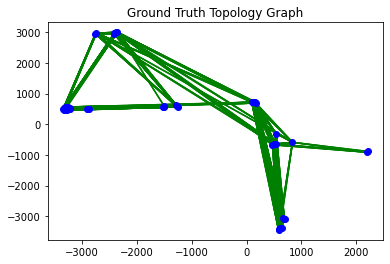

In [8]:
gt_num_edges = 0

fig1 = plt.figure(1)
for node in gt_nodes:
    for neighbor in node.neighbors:
        point1 = node.pos
        point2 = neighbor.pos
        
        x_val = [point1[0], point2[0]]
        y_val = [point1[1], point2[1]]
        plt.plot(x_val, y_val, '-', c='g')
        
        gt_num_edges += 1
        
for node in gt_nodes:
    plt.plot(node.pos[0], node.pos[1], 'o', c='b')

plt.title('Ground Truth Topology Graph')
plt.show()

## Creating SuperGlue Topology Graph

In [9]:
directory = 'SuperGluePretrainedNetwork-master\SuperGluePretrainedNetwork-master\dump_match_pairs'

sg_num_matches = []

for filename in os.scandir(directory):
    if filename.is_file():
        npz = np.load(filename)
        
        sg_num_matches.append(np.sum(npz['matches'] > -1))

sg_num_matches = np.array(sg_num_matches)
sg_matches_ser = pd.Series(sg_num_matches)

print(sg_matches_ser.describe())
sg_matches_ser

count    861.000000
mean      39.609756
std       99.979701
min        0.000000
25%        0.000000
50%        0.000000
75%       10.000000
max      663.000000
dtype: float64


0      518
1      206
2        0
3        0
4        0
      ... 
856      0
857     13
858    144
859    129
860    278
Length: 861, dtype: int32

In [10]:
"""MAY NOT BE NECESSARY"""

sg_matches_ser_norm = (sg_matches_ser - sg_matches_ser.min())/(sg_matches_ser.max()-sg_matches_ser.min())

In [11]:
CMAP = plt.get_cmap('cividis_r').copy()

### ~Determining threshold value~ DEPRECATED

Determined using the minimum match value of the ground truth edges

In [12]:
"""sg_threshold = np.iinfo(np.int32).max
sg_max = np.iinfo(np.int32).min
img_pair = None


for i, filename in enumerate(os.scandir(directory)):
    if filename.is_file():
        # Grab image names
        img1, img2 = filename.name.split('_')[:2]
        img1 = img1+'.jpg'
        img2 = img2+'.jpg'

        # Determine nodes involved
        first, second = None, None
        for node in gt_nodes:
            if img1.__eq__(node.filename):
                first = node
            
            elif img2.__eq__(node.filename):
                second = node
                
                # Check if intersection with GT
                if second in first.neighbors:
                    if sg_matches_ser[i] <= sg_threshold:
                        sg_threshold = sg_matches_ser[i]
                        img_pair = (img1, img2)
                    
                    sg_max = max(sg_max, sg_matches_ser[i])
                    
                break
                    
print("Minimum Threshold for matches: {}".format(sg_threshold))"""

'sg_threshold = np.iinfo(np.int32).max\nsg_max = np.iinfo(np.int32).min\nimg_pair = None\n\n\nfor i, filename in enumerate(os.scandir(directory)):\n    if filename.is_file():\n        # Grab image names\n        img1, img2 = filename.name.split(\'_\')[:2]\n        img1 = img1+\'.jpg\'\n        img2 = img2+\'.jpg\'\n\n        # Determine nodes involved\n        first, second = None, None\n        for node in gt_nodes:\n            if img1.__eq__(node.filename):\n                first = node\n            \n            elif img2.__eq__(node.filename):\n                second = node\n                \n                # Check if intersection with GT\n                if second in first.neighbors:\n                    if sg_matches_ser[i] <= sg_threshold:\n                        sg_threshold = sg_matches_ser[i]\n                        img_pair = (img1, img2)\n                    \n                    sg_max = max(sg_max, sg_matches_ser[i])\n                    \n                break\n     

In [13]:
def superGlueGraph(gt_nodes, gt_num_edges, directory, threshold, CMAP, matches, scaled_matches):    
    sg_num_edges = 0
    sg_intersect = 0

    fig2 = plt.figure(2)
    for i, filename in enumerate(os.scandir(directory)):
        if filename.is_file():
            # Does this edge pass the threshold?
            if matches[i] < threshold:
                continue

            # Grab image names
            img1, img2 = filename.name.split('_')[:2]
            img1 = img1+'.jpg'
            img2 = img2+'.jpg'

            # Determine nodes involved
            point1, point2 = 0, 0
            first, second = None, None
            for node in gt_nodes:
                if img1.__eq__(node.filename):
                    point1 = node.pos
                    first = node

                elif img2.__eq__(node.filename):
                    point2 = node.pos
                    second = node
                    break

            intersect = second in first.neighbors

            x_val = [point1[0], point2[0]]
            y_val = [point1[1], point2[1]]
            plt.plot(x_val, y_val, '-', c=CMAP(scaled_matches[i]), alpha = 0.4)

            # Add to Union
            sg_num_edges += 1

            # Add to Intersection
            if intersect:
                sg_intersect += 1


    for node in gt_nodes:
        plt.plot(node.pos[0], node.pos[1], 'o', c='b')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=0, vmax=1))
    plt.colorbar(sm)

    plt.title('SuperGlue Threshold = {:.2f}'.format(threshold))
    plt.show()
    
    iou = sg_intersect / (gt_num_edges + sg_num_edges - sg_intersect)

    print("IOU: {}".format(iou))
    
    return iou

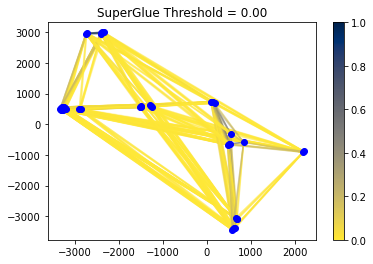

IOU: 0.21441605839416059


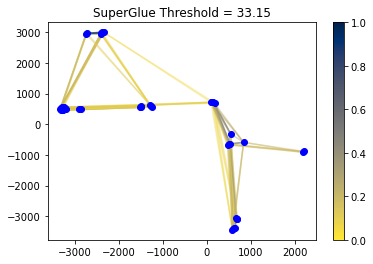

IOU: 0.35443037974683544


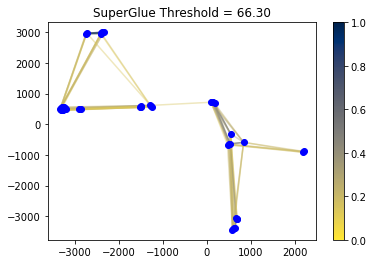

IOU: 0.2872340425531915


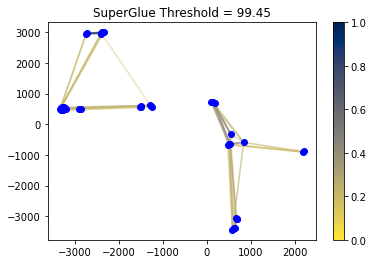

IOU: 0.2404255319148936


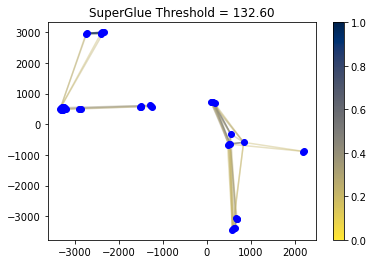

IOU: 0.20425531914893616


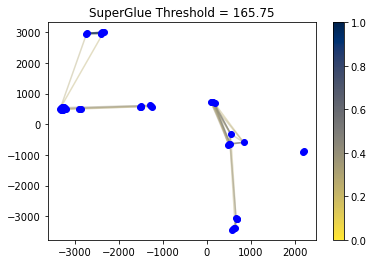

IOU: 0.1574468085106383


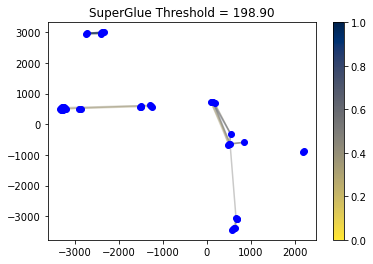

IOU: 0.12127659574468085


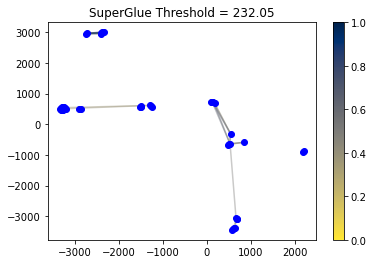

IOU: 0.10212765957446808


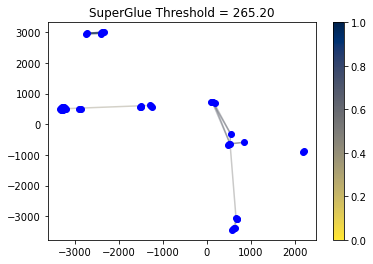

IOU: 0.0851063829787234


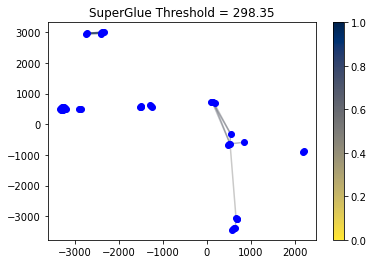

IOU: 0.07234042553191489


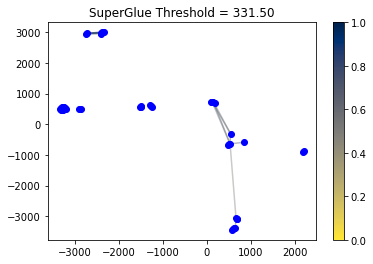

IOU: 0.06382978723404255


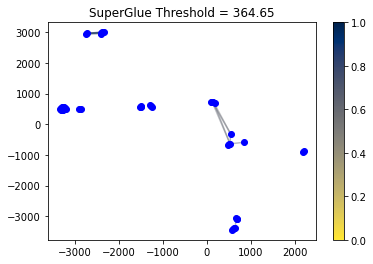

IOU: 0.05319148936170213


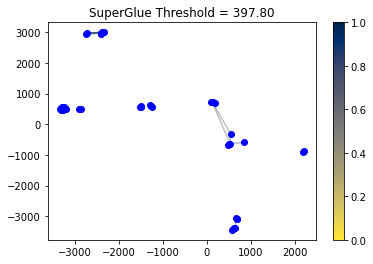

IOU: 0.04680851063829787


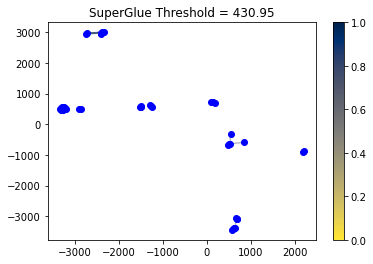

IOU: 0.03404255319148936


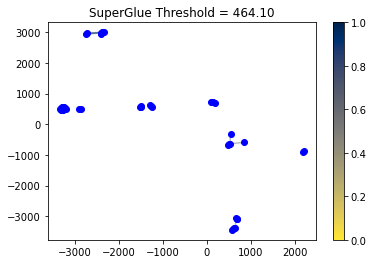

IOU: 0.027659574468085105


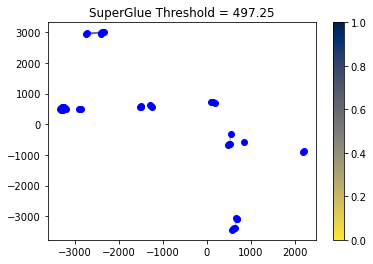

IOU: 0.02127659574468085


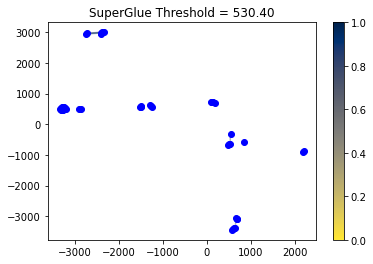

IOU: 0.01702127659574468


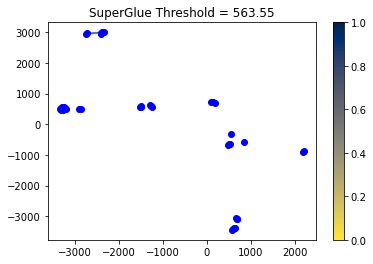

IOU: 0.00851063829787234


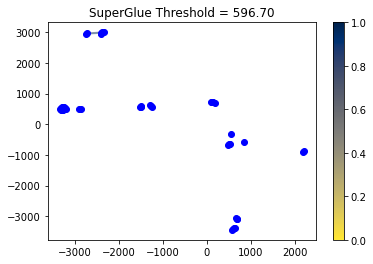

IOU: 0.00425531914893617


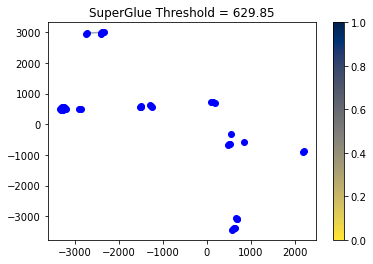

IOU: 0.002127659574468085


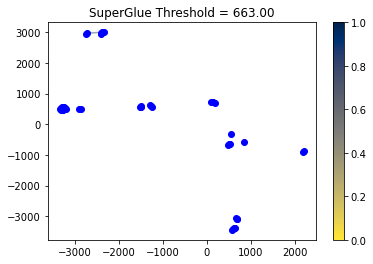

IOU: 0.002127659574468085


In [22]:
thresholds = []
ious = []

for i in range(0, 105, 5):
    percent = i/100
    threshold = np.max(sg_matches_ser) * (percent)
    # Append percent not threshold itself
    thresholds.append(percent)
    
    iou = superGlueGraph(gt_nodes, gt_num_edges, directory, threshold, CMAP, sg_matches_ser, sg_matches_ser_norm)
    ious.append(iou)

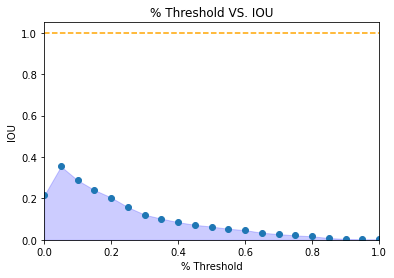

AUC: 0.1058891304176881


In [34]:
# Display Threshold V. IOU graph
def AUC(thresholds, ious):
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)

    plt.title('% Threshold VS. IOU')
    plt.xlabel('% Threshold')
    plt.ylabel('IOU')

    plt.axhline(y=1, color='orange', linestyle='--')

    plt.plot(thresholds, ious, 'o')
    plt.fill_between(thresholds, ious, color = 'b', alpha = 0.2)
    plt.show()

    # Right Riemann Sum
    ious_np = np.array(ious[:-1])
    auc = np.sum(ious_np * 0.05)
    print("AUC: {}".format(auc))

AUC(thresholds, ious)

## Creating RGB Histogram Topology Graphs

In [ ]:
def scale(score, score_list, reverse):
    if reverse:
        neg_scores = np.negative(score_list)
        return (-score - np.min(neg_scores)) / (np.max(neg_scores) - np.min(neg_scores)) 
    return (score - np.min(score_list)) / (np.max(score_list) - np.min(score_list))

In [ ]:
hist_path = "hist_res/"

hist_num_edges = {}
hist_intersect = {}

hist_thresholds = {}

for method in glob.glob(hist_path + "/*.txt"):
    # Get method name
    method_name = method[method.rfind('_') + 1:][:-4]
    
    reverse = False
    
    fig3 = plt.figure(3)
    plt.title('{} Distance Histogram Topology Graph'.format(method_name))
    
    # Check if method type is "lower is better" or "larger is better"
    if method_name.__eq__('Chi-Sq') or method_name.__eq__('Hellinger'):
        reverse = True
        hist_thresholds[method_name] = np.iinfo(np.int32).min
    else:
        hist_thresholds[method_name] = np.iinfo(np.int32).max

    score_list = []
    
    hist_num_edges[method_name] = 0
    hist_intersect[method_name] = 0
    
    # Plotting
    with open(method, 'r') as f:
        lines = f.readlines()
        
        # Grab scores and threshold beforehand
        first, second = None, None
        for line in lines:
            score_list.append(float(line.split()[-1]))
            
            img1, img2, score = line.split()
            
            for node in gt_nodes:
                if img1.__eq__(node.filename):
                    first = node
                if img2.__eq__(node.filename):
                    second = node
                    break
            
            # If edge in Ground Truth
            if second in first.neighbors:
                # Determine new threshold
                if reverse:
                    hist_thresholds[method_name] = max(hist_thresholds[method_name], float(score))
                else:
                    hist_thresholds[method_name] = min(hist_thresholds[method_name], float(score))
                
        #score_list = np.array(score_list)
        print("Threshold for {}: {}".format(method_name, hist_thresholds[method_name]))
          
        point1, point2 = 0,0
        for line in lines:
            img1, img2, score = line.split()
            
            # Determine if edge meets threshold
            if reverse:
                if float(score) > hist_thresholds[method_name]:
                    continue
            else:
                if float(score) < hist_thresholds[method_name]:
                    continue

            # Determine point positions
            for node in gt_nodes:
                if img1.__eq__(node.filename):
                    point1 = node.pos
                    first = node
            
                elif img2.__eq__(node.filename):
                    point2 = node.pos
                    second = node
                    break
            
            # Determine scaled score for edge strength
            score = scale(float(score), score_list, reverse)
            
            intersect = second in first.neighbors
            
            # Plot edges
            x_val = [point1[0], point2[0]]
            y_val = [point1[1], point2[1]]
            
            plt.plot(x_val, y_val, '-', c=CMAP(score), alpha = 0.4)
            
            # Add to Union
            hist_num_edges[method_name] += 1
            
            # Add to Intersection
            if intersect:
                hist_intersect[method_name] += 1
            
    # Plot nodes
    for node in gt_nodes:
        plt.plot(node.pos[0], node.pos[1], 'o', c='b')
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=0, vmax=1))
    plt.colorbar(sm)
    
    plt.show()

    print("{} IOU: {}\n".format(method_name, (hist_intersect[method_name] / (gt_num_edges + hist_num_edges[method_name] - hist_intersect[method_name]))))